In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from glob import glob
from bs4 import BeautifulSoup
import imutils 
import mimetypes
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from google.colab.patches import cv2_imshow
import os
from imutils import paths


In [ ]:
!wget https://github.com/tirmir/cat_dog_objdetect/raw/main/dataset.zip

--2022-06-16 16:32:58--  https://github.com/tirmir/cat_dog_objdetect/raw/main/dataset.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tirmir/cat_dog_objdetect/main/dataset.zip [following]
--2022-06-16 16:32:58--  https://raw.githubusercontent.com/tirmir/cat_dog_objdetect/main/dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25213761 (24M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  24.04M   148MB/s    in 0.2s    

2022-06-16 16:33:00 (148 MB/s) - ‘dataset.zip’ saved [25213761/25213761]



In [ ]:
!unzip dataset.zip
!rm dataset.zip

Archive:  dataset.zip
  inflating: dataset/annotations/cat.csv  
  inflating: dataset/annotations/dog.csv  
  inflating: dataset/images/cat/cat.3558.jpg  
  inflating: dataset/images/cat/cat.3565.jpg  
  inflating: dataset/images/cat/cat.3570.jpg  
  inflating: dataset/images/cat/cat.3567.jpg  
  inflating: dataset/images/cat/cat.3552.jpg  
  inflating: dataset/images/cat/cat.3560.jpg  
  inflating: dataset/images/cat/cat.3580.jpg  
  inflating: dataset/images/cat/cat.3563.jpg  
  inflating: dataset/images/cat/cat.3557.jpg  
  inflating: dataset/images/cat/cat.3562.jpg  
  inflating: dataset/images/cat/cat.3561.jpg  
  inflating: dataset/images/cat/cat.3582.jpg  
  inflating: dataset/images/cat/cat.3553.jpg  
  inflating: dataset/images/cat/cat.3559.jpg  
  inflating: dataset/images/cat/cat.3551.jpg  
  inflating: dataset/images/cat/cat.3535.jpg  
  inflating: dataset/images/cat/cat.3549.jpg  
  inflating: dataset/images/cat/cat.3547.jpg  
  inflating: dataset/images/cat/cat.3534.jpg  

In [ ]:
all_paths = {
    'base_path':'dataset',
    'images_path': os.path.join('dataset', 'images'),
    'annots_path': os.path.join('dataset', 'annotations'),
    'base_output': 'output',
    'model_path' : os.path.join('output', 'detector.h5'),
    'lb_path' : os.path.join('output', 'lb.pickle'),
    'plots_path': os.path.join('output', 'plots'),
    'test_paths': os.path.join('output', 'test_paths.txt'),
    'cat_img': os.path.join('dataset', 'images', 'cat'),
    'dog_img': os.path.join('dataset', 'images', 'dog')
    
}

In [ ]:
for path in all_paths.values():
  if not os.path.exists(path):
    if not '.' in path:
      !mkdir -p {path}


###Preprocessing
---

In [ ]:
data = []
labls = []
boxes = []
imagePaths = []

for Path in paths.list_files(all_paths['annots_path'], validExts=(".csv")):
  rows = open(Path).read().strip().split('\n')
  for row in rows:
    row = row.split(',')
    filename, X1, Y1, X2, Y2, label = row
    imagePath = os.path.join(all_paths['images_path'], filename.split('.')[0],
			filename)
    image = cv2.imread(imagePath)
    h, w = image.shape[:2]
    X1 = float(X1)/w
    Y1 = float(Y1)/h
    X2 = float(X2)/w
    Y2 = float(Y2)/h

    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)

    data.append(image)
    labls.append(label)
    boxes.append((X1, Y1, X2, Y2))
    imagePaths.append(imagePath)


In [ ]:
data = np.array(data, dtype="float32") / 255.0
labls = np.array(labls)
boxes = np.array(boxes, dtype="float32")
imagePaths = np.array(imagePaths)

lb = LabelBinarizer()
labls = lb.fit_transform(labls)
labls = to_categorical(labls)

In [ ]:
split = train_test_split(data, labls, boxes, imagePaths,
	test_size=0.15, random_state=42)

trainImgs, testImgs, trainLabls, testLabls= split[:4]
trainBoxes, testBoxes, trainPaths, testPaths = split[4:]

f = open(all_paths['test_paths'], "w")
f.write("\n".join(testPaths))
f.close()

##Training
---

In [ ]:
#Hyperparameters

INIT_LR = 1e-4
NUM_EPOCHS = 20
BATCH_SIZE = 32

In [ ]:
#Model Architecture Tuned transfer learning of vgg architecture
#Two seperate branches for head layers are created. One for bounding box predection and the other for class prediction

vgg = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

vgg.trainable = False

flatten = vgg.output
flatten = Flatten()(flatten)

boundbox = Dense(128, activation="relu")(flatten)
boundbox = Dropout(0.2)(boundbox)
boundbox = Dense(64, activation="relu")(boundbox)
boundbox = Dropout(0.2)(boundbox)
boundbox = Dense(32, activation="relu")(boundbox)
boundbox = Dense(4, activation="sigmoid",
	name="bounding_box")(boundbox)

labels = Dense(512, activation="relu")(flatten)
labels = Dropout(0.5)(labels)
labels = Dense(512, activation="relu")(labels)
labels = Dropout(0.5)(labels)
labels = Dense(2, activation="sigmoid",
	name="class_label")(labels)

model = Model(
	inputs=vgg.input,
	outputs=(boundbox, labels))

In [ ]:
#parameter defination for two seperate branches of head layers and model compiling

losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}

lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}

trainTargets = {
	"class_label": trainLabls,
	"bounding_box": trainBoxes
}

testTargets = {
	"class_label": testLabls,
	"bounding_box": testBoxes
}

opt = Adam(lr=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                                )                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#Training the model

H = model.fit(
	trainImgs, trainTargets,
	validation_data=(testImgs, testTargets),
	batch_size=BATCH_SIZE,
	epochs=NUM_EPOCHS,
	verbose=1)

model.save(all_paths['model_path'], save_format="h5")

f = open(all_paths['lb_path'], "wb")
f.write(pickle.dumps(lb))
f.close()

Epoch 1/20
30/30 [==============================] - 9s 262ms/step - loss: 0.7849 - bounding_box_loss: 0.0829 - class_label_loss: 0.7020 - bounding_box_accuracy: 0.4877 - class_label_accuracy: 0.6246 - val_loss: 0.4648 - val_bounding_box_loss: 0.0157 - val_class_label_loss: 0.4492 - val_bounding_box_accuracy: 0.6788 - val_class_label_accuracy: 0.7818
Epoch 2/20
30/30 [==============================] - 5s 183ms/step - loss: 0.4702 - bounding_box_loss: 0.0277 - class_label_loss: 0.4425 - bounding_box_accuracy: 0.5754 - class_label_accuracy: 0.8032 - val_loss: 0.3643 - val_bounding_box_loss: 0.0186 - val_class_label_loss: 0.3457 - val_bounding_box_accuracy: 0.6788 - val_class_label_accuracy: 0.8364
Epoch 3/20
30/30 [==============================] - 5s 184ms/step - loss: 0.3376 - bounding_box_loss: 0.0236 - class_label_loss: 0.3140 - bounding_box_accuracy: 0.5636 - class_label_accuracy: 0.8749 - val_loss: 0.3117 - val_bounding_box_loss: 0.0192 - val_class_label_loss: 0.2925 - val_bounding_

###Evaluation
---

In [106]:
#Print train and validation loss for two seperate branches of the head, and the total loss of the model (each loss contribute equally)

lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))

for (i, l) in enumerate(lossNames):

	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()

plt.tight_layout()
plotPath = os.path.sep.join([all_paths['plots_path'], "losses.png"])
plt.savefig(plotPath)
plt.close()

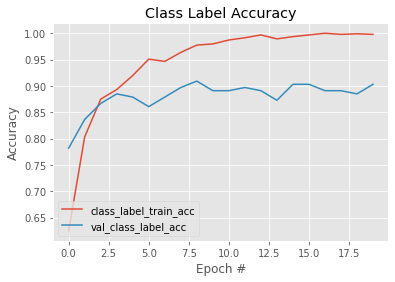

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plotPath = os.path.sep.join([all_paths['plots_path'], "accs.png"])
plt.savefig(plotPath)